In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial import KDTree
from shapely.affinity import translate
from shapely.ops import nearest_points
from shapely.affinity import rotate
import math

In [2]:
import sys
print(sys.executable)
print(sys.version)

C:\Users\Alina\Desktop\Python\!Работа IT ННГ\Infill_drilling\Infill_drilling\.venv\Scripts\python.exe
3.11.4 (tags/v3.11.4:d2340ef, Jun  7 2023, 05:45:37) [MSC v.1934 64 bit (AMD64)]


In [3]:
# Папка с файлом jupyter
current_folder_name = os.path.basename(os.getcwd())
# Установите корневую директорию проекта как текущий рабочий каталог
project_root = r"C:/Users/Alina/Desktop/Python/!Работа IT ННГ/Infill_drilling/Infill_drilling"
os.chdir(project_root)
sys.path.append(os.path.abspath("app"))
# Путь для сохранения
save_directory = r"output/Крайнее_Ю1/архив"

plt.rcParams['figure.figsize'] = [12, 8] 

# Загрузка исходных данных и определение параметров расчета

In [4]:
with open(f"{save_directory}/maps.pkl", 'rb') as f:
    maps = pickle.load(f)

with open(f"{save_directory}/data_wells+.pkl", 'rb') as f: 
    data_wells = pickle.load(f)

type_map_list = list(map(lambda raster: raster.type_map, maps))

# data_updated_saturations = np.load(f"{save_directory}//updated_saturation.npy")

In [5]:
import json

name_folder = "data_for_maps"
os.makedirs(name_folder, exist_ok=True)

maps_meta = []
for i, map_obj in enumerate(maps):
    map_dict = {
        "data_file": f"{name_folder}/map_{map_obj.type_map}.npy",
        "geo_transform": map_obj.geo_transform,
        "projection": map_obj.projection,
        "type_map": map_obj.type_map
    }
    # Сохраняем массив отдельно
    np.save(map_dict["data_file"], map_obj.data)
    
    # Удалим путь из словаря, сохраним только имя
    map_dict["data_file"] = os.path.basename(map_dict["data_file"])

    maps_meta.append(map_dict)

with open(f"{name_folder}/maps_metadata.json", "w", encoding="utf-8") as f:
    json.dump(maps_meta, f, ensure_ascii=False, indent=2)

In [6]:
# Константы
default_size_pixel = 50 # размер ячейки карты в м = int/None
cell_area = default_size_pixel**2
Bo = 1.241
K_vyt  = 0.372639931461163
KIN = 0.336
pho = 0.75 # плотность нефти в пластовых усл
pho_surf = 0.841
Sor = 0.3 # остаточная нефтенасыщенность | д.ед

# Трещины АГРП
switch_fracture = False
sigma_h = math.radians(45)
# Есть несколько вариантов расчета - через закачку и длину
l_half_fracture = 150/default_size_pixel

**Отделение выборки для расчета**

In [7]:
# Расчет на куске карты
# list_wells = ['58P','6032', '6035','6036','6040','6041','6045','6045_1','6046','6046_1','6047','6048','6049','6050','6051','6204',
#               '6290','6291','6292','6704','6707','6712','6950','6951','6952','6953','6954','6955','6956','6957','6958','6959','6960','69P']
# all=0

In [8]:
# Расчет на всех скважинах
list_wells = data_wells.well_number
all = 1

In [9]:
data_wells.columns

Index(['well_number', 'work_marker', 'well_status', 'well_type', 'date',
       'Qo_rate', 'Qo_rate_TR', 'init_Qo_rate_TR', 'Ql_rate', 'Ql_rate_TR',
       'init_Ql_rate_TR', 'Qo', 'Ql', 'water_cut', 'water_cut_TR',
       'init_water_cut', 'init_water_cut_TR', 'Winj_rate_TR', 'Winj_rate',
       'Winj', 'time_work', 'time_work_prod', 'time_work_inj', 'P_well',
       'init_P_well_prod', 'init_P_well_inj', 'no_work_time', 'Qo_cumsum',
       'Winj_cumsum', 'init_Qo_rate', 'init_Ql_rate', 'r_eff_not_norm',
       'r_eff_voronoy', 'r_eff', 'P_reservoir', 'init_P_reservoir_prod', 'NNT',
       'm', 'So', 'permeability', 'T1_x_geo', 'T1_y_geo', 'T3_x_geo',
       'T3_y_geo', 'length_geo', 'T1_x_pix', 'T1_y_pix', 'T3_x_pix',
       'T3_y_pix', 'length_pix', 'azimuth', 'POINT_T1_geo', 'POINT_T3_geo',
       'LINESTRING_geo', 'MULTILINESTRING_geo', 'POINT_T1_pix', 'POINT_T3_pix',
       'LINESTRING_pix', 'MULTILINESTRING_pix', 'well_number_digit',
       'type_wellbore', 'first_well_date', 'n

In [10]:
data_wells = data_wells[data_wells.well_number.isin(list_wells)]
data_wells = data_wells[(data_wells['Qo_cumsum'] > 0) | (data_wells['Winj_cumsum'] > 0)].reset_index(drop=True)
# добавление колонок свойств для расчета из файла ГФХ
data_wells['Bo'] = Bo # объемный коэффициент нефти, д.ед
data_wells['rho'] = pho_surf  # плотность нефти в поверхностных условиях, г/см3

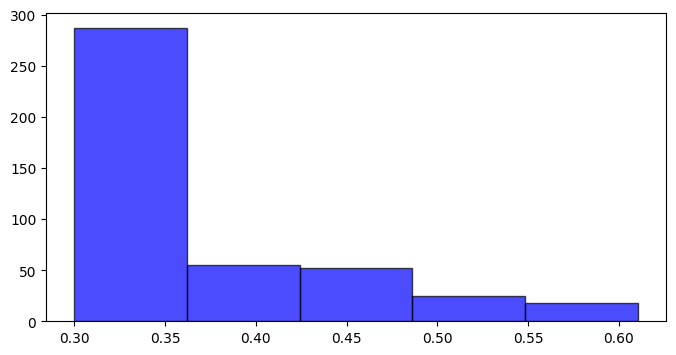

0.3

In [11]:
# Обратотка значений нефтенасыщенности скважин
data_wells['Soil'] = np.where(data_wells.work_marker == 'inj', Sor, data_wells['Soil'])
# Построение диаграммы распределения
plt.figure(figsize=(8, 4))
plt.hist(data_wells.Soil, bins=5, color='blue', alpha=0.7, edgecolor='black')
plt.show()
data_wells.Soil.min()

In [12]:
data_wells.Qo_cumsum.sum()

8752395.4

In [13]:
data_wells[data_wells.Soil > 0.6][['well_number', 'Soil', 'So', 'water_cut']]

,well_number,Soil,So,water_cut
81,6007,0.604233,0.613459,2.726789
204,6196,0.610567,0.651826,10.936779


In [14]:
data_wells[data_wells.well_number == "6707"][['well_number', 'Soil', 'So', 'water_cut']]

,well_number,Soil,So,water_cut
351,6707,0.568874,0.579393,3.48997


**Вырезаем участки карт**

In [15]:
x, y = [], []
for _, row in data_wells.iterrows():
    x.append(row['POINT_T1_pix'].x)
    x.append(row['POINT_T3_pix'].x)
    y.append(row['POINT_T1_pix'].y)
    y.append(row['POINT_T3_pix'].y)

# Рамки для обрезки карт
if all:
    x_min, x_max = 0, maps[type_map_list.index("initial_oil_saturation")].data.shape[1]
    y_min, y_max = 0, maps[type_map_list.index("initial_oil_saturation")].data.shape[0]
else:
    buff = 1000 / default_size_pixel
    x_min, x_max = int(min(x) - buff if min(x) - buff > 0 else 0),  int(max(x) + buff)
    y_min, y_max = int(min(y) - buff if min(y) - buff > 0 else 0), int(max(y) + buff)

# Куски карт для расчета 
data_saturation = maps[type_map_list.index("initial_oil_saturation")].data[y_min : y_max, x_min : x_max]
data_saturation[data_saturation < Sor] = 0
data_NNT = maps[type_map_list.index("NNT")].data[y_min : y_max, x_min : x_max]
data_porosity = maps[type_map_list.index("porosity")].data[y_min : y_max, x_min : x_max]
# data_net_thickness = maps[type_map_list.index("net_thickness")].data[y_min : y_max, x_min : x_max]
# data_updated_saturations = data_updated_saturations[y_min : y_max, x_min : x_max]
data_rrr = maps[type_map_list.index("residual_recoverable_reserves")].data[y_min : y_max, x_min : x_max]

# Пересчет координат скважин под новую систему
data_wells['T1_x_new'] = data_wells['T1_x_pix'] - x_min
data_wells['T1_y_new'] = data_wells['T1_y_pix'] - y_min
data_wells['T3_x_new'] = data_wells['T3_x_pix'] - x_min
data_wells['T3_y_new'] = data_wells['T3_y_pix'] - y_min

data_wells["POINT_T1_new"] = list(map(lambda x, y: Point(x, y), data_wells['T1_x_new'], data_wells['T1_y_new']))
data_wells["POINT_T3_new"] = list(map(lambda x, y: Point(x, y), data_wells['T3_x_new'], data_wells['T3_y_new']))
data_wells["LINESTRING_new"] = list(map(lambda x, y: LineString([x, y]), data_wells["POINT_T1_new"], data_wells["POINT_T3_new"]))

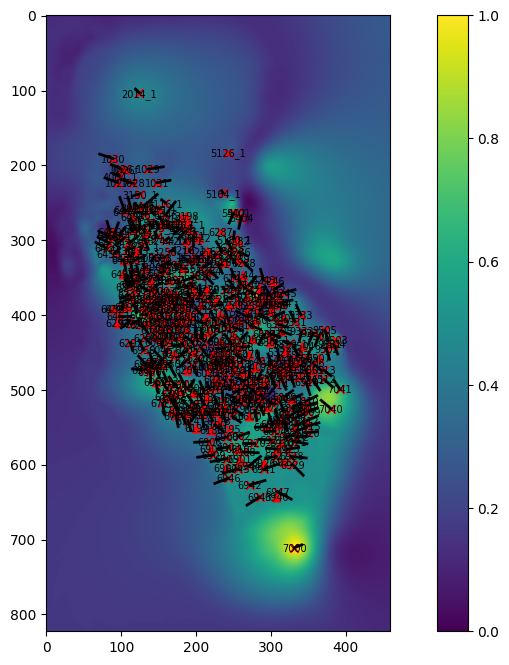

In [16]:
# Визуализация для проверки обрезки
plt.imshow(data_porosity, origin="lower")
for well_geom in data_wells["LINESTRING_new"]:
    x_line, y_line = well_geom.xy
    plt.plot(x_line, y_line, color="black", linewidth=2)
x_pix, y_pix = np.array(data_wells[data_wells['work_marker']=='prod'].T1_x_new), np.array(data_wells[data_wells['work_marker']=='prod'].T1_y_new)
plt.scatter(x_pix, y_pix, c="red", marker="x", label="Скважины")  # Отмечаем скважины
x_pix, y_pix = np.array(data_wells[data_wells['work_marker']=='inj'].T1_x_new), np.array(data_wells[data_wells['work_marker']=='inj'].T1_y_new)
plt.scatter(x_pix, y_pix, c="red", marker='^', label="Скважины")  # Отмечаем скважины

# Подписи для скважин с смещением
for i in range(len(data_wells['well_number'])):
    plt.text(data_wells['T1_x_new'][i], data_wells['T1_y_new'][i]+5, f"{data_wells['well_number'][i]}", fontsize=7, ha='center')

plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

**Построение доп карт и обновление координат**

In [17]:
# Карта объемов для оптимизации
data_volumes = cell_area * data_NNT * data_porosity

# Расчет сетки 
x_coords = np.arange(0, data_volumes.shape[1], 1)
y_coords = np.arange(0, data_volumes.shape[0], 1)
x_mesh, y_mesh = np.meshgrid(x_coords, y_coords)
cells = pd.DataFrame({'x': x_mesh.ravel(), 'y': y_mesh.ravel()})

grid_points = np.column_stack((x_mesh.ravel(), y_mesh.ravel()))

Для учета ГС будем считать скважины набором точек на карте. Для каждой точки простанства будем брать минимальное расстояние от всего набора точек скважины.

In [18]:
# Для всех скважин добавим в колонки trajectory_x, trajectory_y - списки координат сетки принадлежащих скважинам
from skimage.draw import line
def get_line_cells(x1, y1, x2, y2):
    if x1 == x2 and y1 == y2:
        return [x1], [y1]
    rr, cc = line(int(y1), int(x1), int(y2), int(x2))  # skimage.draw.line возвращает индексы
    return cc.tolist(), rr.tolist()

data_wells['trajectory_x'], data_wells['trajectory_y'] = zip(*data_wells.apply(lambda row: get_line_cells(int(row['T1_x_new']), int(row['T1_y_new']), int(row['T3_x_new']), int(row['T3_y_new'])), axis=1))

## Подготовка данных для определения текущей насыщенности

### Пересчитаем для нагнетательных скважин эффективный радиус

In [19]:
# Список добывающих скважин, для которых будет произведен расчет матриц взаимодействия
list_prod_wells = data_wells[data_wells.work_marker == 'prod'].well_number.to_list()
# Фрейм нагнетательных скважин
df_inj_wells = data_wells[data_wells.work_marker == 'inj']

data_wells_eff_r = data_wells.copy()

**Доли компенсации отбора жидкости**

In [20]:
max_distance_inj_prod = 1000 # расстояние для поика соседних нагнетательных
df_interferense_matrix = pd.DataFrame(columns=df_inj_wells.well_number, index=list_prod_wells, data=0.0)

gdf_inj_wells = gpd.GeoDataFrame(df_inj_wells, geometry="LINESTRING_pix")

def calc_interferense_matrix(wells_inj, prod_well):
    "Расчет коэффициентов участия для нагнетательных скважин"
    lambda_ij = wells_inj.NNT * wells_inj.Winj_cumsum / wells_inj['distance']
    lambda_ij = lambda_ij / lambda_ij.sum()
    lambda_ij = lambda_ij.to_numpy().reshape(1, wells_inj.shape[0])
    return pd.DataFrame(columns=wells_inj.well_number.to_list(), index=[prod_well], data=lambda_ij)
    
for prod_well in list_prod_wells:
    geometry_prod_well = gpd.GeoDataFrame(data_wells_eff_r[data_wells_eff_r.well_number == prod_well], geometry="LINESTRING_pix")['LINESTRING_pix'].iloc[0]
    gdf_inj_wells['distance'] = geometry_prod_well.distance(gdf_inj_wells['LINESTRING_pix'])  
    # выделим ближайште скважины
    df_inj_wells_nearest = gdf_inj_wells[gdf_inj_wells['distance'] <= max_distance_inj_prod]
    if not df_inj_wells_nearest.empty:
        df_interferense_matrix.update(calc_interferense_matrix(df_inj_wells_nearest, prod_well))
        
df_interferense_matrix

well_number,1003_1,3198,4145_1,4147_1,4160_1,4174_1,4177_1,4200_1,4227_1,4245_1,...,6922,6924,6926,6930,6940,6951,6953,6957,9501,9504
1026,0.000605,0.000793,0.010243,0.026660,0.005582,0.000623,0.026039,0.004706,0.006575,0.001515,...,0.000701,0.000501,0.001559,0.001850,0.000004,0.000718,0.014605,0.002546,0.002475,0.000003
1026f,0.000608,0.000816,0.010717,0.027457,0.005735,0.000643,0.026678,0.004788,0.006658,0.001515,...,0.000695,0.000498,0.001547,0.001837,0.000004,0.000711,0.014493,0.002524,0.002469,0.000003
1027,0.000634,0.000784,0.010865,0.026651,0.005810,0.000661,0.025946,0.004765,0.006521,0.001628,...,0.000680,0.000488,0.001517,0.001797,0.000004,0.000722,0.014672,0.002548,0.002380,0.000003
1028,0.000645,0.000905,0.014146,0.030933,0.006687,0.000787,0.029253,0.005178,0.006915,0.001609,...,0.000658,0.000472,0.001464,0.001742,0.000003,0.000691,0.014099,0.002437,0.002354,0.000003
1029,0.000593,0.001066,0.012450,0.034774,0.006415,0.000709,0.032828,0.005369,0.007503,0.001416,...,0.000672,0.000480,0.001486,0.001783,0.000004,0.000662,0.013565,0.002352,0.002528,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9334,0.000166,0.000157,0.001144,0.004991,0.000945,0.000088,0.005788,0.001223,0.002452,0.000349,...,0.000830,0.000613,0.001701,0.002435,0.000004,0.000383,0.008237,0.001481,0.014696,0.000014
9500,0.000172,0.000164,0.001194,0.005191,0.000983,0.000092,0.006007,0.001265,0.002522,0.000363,...,0.000894,0.000657,0.001818,0.002612,0.000004,0.000396,0.008513,0.001537,0.024217,0.000021
9502,0.000169,0.000160,0.001179,0.005082,0.000966,0.000091,0.005859,0.001233,0.002423,0.000360,...,0.001010,0.000733,0.001999,0.002938,0.000004,0.000392,0.008395,0.001525,0.060273,0.000044
9503,0.000199,0.000192,0.001411,0.006085,0.001151,0.000108,0.007010,0.001465,0.002881,0.000422,...,0.001031,0.000741,0.002075,0.002931,0.000005,0.000446,0.009526,0.001727,0.048514,0.000092


In [21]:
def calc_r_eff(cumulative_value, B, ro, eff_h, m, So, type_well, len_well, So_min):
    """
    calculate drainage radius of production well
    :param cumulative_value: cumulative oil production or cumulative_water_inj, tons|m3
    :param B: volumetric ratio of oil|water
    :param ro: density oli|water g/cm3
    :param eff_h: effective thickness, m
    :param m: reservoir porosity, units
    :param So: initial oil saturation, units
    :param type_well: "vertical" or "horizontal"
    :param len_well: length of well for vertical well
    :param So_min: minimum oil saturation, units
    :return:
    """
    if So - So_min < 0:
        So = So_min
    if type_well == "vertical":
        a = cumulative_value * B
        b = ro * math.pi * eff_h * m * (So - So_min)
        if b == 0:
            return 0
        else:
            return math.sqrt(a / b)
    elif type_well == "horizontal":
        L = len_well
        a = math.pi * cumulative_value * B
        b = eff_h * m * ro * (So - So_min)
        if b == 0:
            return 0
        else:
            return (-1 * L + math.sqrt(L * L + a / b)) / math.pi
    else:
        raise NameError(f"Wrong well type: {type_well}. Allowed values: vertical or horizontal")


def well_effective_radius(row, default_radius, So_min, NUMBER_MONTHS=120, default_radius_inj=300):
    """
    Расчет радиуса дренирования/нагнетания на основе параметров разработки
    Parameters
    ----------
    row - строка из data_wells
    default_radius - радиус по умолчанию (технически минимальный) для добывающего фонда
    NUMBER_MONTHS - Количество месяцев для отнесения скважин к действующим
    default_radius_inj - радиус по умолчанию (технически минимальный) для нагнетательного фонда

    Returns R_eff
    -------

    """
    #!!!! для всехсчитаем как для нефтяных
    work_type_well = 'prod'
    len_well = row["length_geo"].iloc[0]
    well_type = row["well_type"].iloc[0]
    eff_h = row["NNT"].iloc[0]
    m = row["m"].iloc[0]
    So = row["So"].iloc[0]
    if work_type_well == "prod":
        # Проверка на длительность работы
        if row['no_work_time'].iloc[0] > NUMBER_MONTHS:
            return default_radius
        else:
            cumulative_oil_prod = row.Qo_cumsum.iloc[0]
            Bo = row.Bo.iloc[0]
            ro_oil = row.rho.iloc[0]
            R_eff = calc_r_eff(cumulative_oil_prod, Bo, ro_oil, eff_h, m, So, well_type, len_well, So_min)
            if not R_eff or R_eff < default_radius:
                R_eff = default_radius
            return R_eff
    elif work_type_well == "inj":
        if row['no_work_time'].iloc[0] > NUMBER_MONTHS:
            return default_radius_inj
        else:
            cumulative_water_inj = row.Winj_cumsum
            R_eff = calc_r_eff(cumulative_water_inj, 1, 1, eff_h, m, So, well_type, len_well, So_min)
            if not R_eff or R_eff < default_radius_inj:
                R_eff = default_radius_inj
            return R_eff


In [22]:
# Для нагнетательных скважин можно рассчитать радиус полезной закачки 
for inj_well in df_interferense_matrix.columns:
    V_interferense_wells = df_interferense_matrix[df_interferense_matrix[inj_well] > 0].index.map(
        lambda x: data_wells_eff_r.loc[data_wells_eff_r.well_number == x]['Qo_cumsum'].iloc[0])
    V_useful_injection = np.sum(V_interferense_wells * df_interferense_matrix[df_interferense_matrix[inj_well] > 0][inj_well].to_numpy())

    data_wells_eff_r.loc[data_wells['well_number'] == inj_well, 'Qo_cumsum'] = V_useful_injection
    
    data_wells_eff_r.loc[data_wells['well_number'] == inj_well, 'r_eff_not_norm'] = well_effective_radius(data_wells_eff_r[data_wells_eff_r['well_number'] == inj_well], 
                                                                                                    default_radius=50, 
                                                                                                    So_min=Sor, 
                                                                                                    NUMBER_MONTHS=120, 
                                                                                                    default_radius_inj=300)
data_wells['r_eff_not_norm'] = data_wells_eff_r['r_eff_not_norm']

In [23]:
# очистим немного память на промежуточном шаге
del df_interferense_matrix
del data_wells_eff_r

### Cформируем вектора параметров каждой точки скважин для оптимизации

In [24]:
def correction_injection_well_trajectory(coords_x, coords_y, sigma_h, l_half_fracture):
    """Переориентация траектории нагнетательных скважин, учитывая направление минимального горизонтального напряжения"""
    # Определеим координаты центра трещины
    center_x, center_y = coords_x[len(coords_x)//2], coords_y[len(coords_y)//2]
    # Азимут трещины
    azimuth_fracture = sigma_h + math.pi/2
    new_t1_x, new_t1_y = center_x + l_half_fracture * math.cos(azimuth_fracture), center_y + l_half_fracture * math.sin(azimuth_fracture)
    new_t3_x, new_t3_y = center_x - l_half_fracture * math.cos(azimuth_fracture), center_y - l_half_fracture * math.sin(azimuth_fracture)
    return get_line_cells(new_t1_x, new_t1_y, new_t3_x, new_t3_y)

In [25]:
def calculate_current_saturation_points(row, S_H0, dict_parameters_coefficients):
    """
    Возвращает список current_saturation по каждой точке траектории скважины.
    """
    traj_x = row['trajectory_x']
    traj_y = row['trajectory_y']
    saturations = []
    So_init = []

    for x, y in zip(traj_x, traj_y):
        # Получаем нефтенасыщенность из карты
        So_point = S_H0[y, x]

        # Копируем строку, чтобы не менять исходную
        row_copy = row.copy()
        row_copy['So'] = So_point

        # Рассчитываем текущую нефтенасыщенность для точки
        current_so = get_current_So(row_copy, dict_parameters_coefficients)

        saturations.append(current_so)
        So_init.append(So_point)

    return pd.Series([So_init, saturations])

In [26]:
def get_current_So(row, dict_parameters_coefficients):
    """
    Определение текущей водонасыщенности и нефтенасыщенности
    Parameters
    ----------
    Returns
    -------
    Текущая нефтенасыщенность на скважине
    """
    # Переопределим параметры из словаря
    kv_kh, Swc, Sor, Fw, m1, Fo, m2, Bw = (
        list(map(lambda name: dict_parameters_coefficients['default_well_params'][name],
                 ['kv_kh', 'Swc', 'Sor', 'Fw', 'm1', 'Fo', 'm2', 'Bw'])))
    Swc = 1 - row['So']
    KIN = 0.336
#     Sor_KIN = row['So'] * (1 - KIN)
#     Sor = max(Sor_KIN, Sor)
    reservoir_params = dict_parameters_coefficients['reservoir_params']
    reservoir_params['f_w'] = row['water_cut']
    fluid_params = dict_parameters_coefficients['fluid_params']

    # Выделение необходимых параметров пластовой жидкости
    mu_w, mu_o, Bo, c_o, c_w = list(map(lambda key: fluid_params[key], ['mu_w', 'mu_o', 'Bo', 'c_o', 'c_w']))
    # Выделение необходимых параметров пласта
    f_w, c_r = list(map(lambda key: reservoir_params[key], ['f_w', 'c_r']))

    if row.Winj_rate == 0:
        # Текущая водонасыщенность
        Sw = get_sw(mu_w, mu_o, Bo, Bw, f_w, Fw, m1, Fo, m2, Swc, Sor)
        return 1 - Sw
    else:
        return Sor

In [27]:
from scipy.optimize import bisect
def get_sw(mu_w, mu_o, Bo, Bw, f_w, Fw, m1, Fo, m2, Swc, Sor):
    """
    Водонасыщенность пласта от обводненности f_w (решение обратной задачи делением пополам)
    """
    Sw_min = Swc  # нижняя граница интервала поиска решения
    Sw_max = 1 - Sor  # верхняя граница интервала поиска решения
    # проверка краевых значений
    if f_w <= get_f_w(mu_w, mu_o, Bo, Bw, Sw_min, Fw, m1, Fo, m2, Swc, Sor):
        Sw = Sw_min
    elif f_w >= get_f_w(mu_w, mu_o, Bo, Bw, Sw_max, Fw, m1, Fo, m2, Swc, Sor):
        Sw = Sw_max
    else:
        Sw = bisect(lambda Sw: f_w - get_f_w(mu_w, mu_o, Bo, Bw, Sw, Fw, m1, Fo, m2, Swc, Sor), Sw_min, Sw_max)
        # доп параметры: xtol=0.0001 необходимая точность решения, maxiter=1000 максимальное число итераций
    return Sw


def get_f_w(mu_w, mu_o, Bo, Bw, Sw, Fw, m1, Fo, m2, Swc, Sor):
    """
    Обводненность продукции скважины от водонасыщенности Sw - Функция Баклея-Леверетта
    """
    k_rw = get_k_corey(Fw, m1, Swc, Sor, Sw, type="water")  # ОФП по воде
    k_ro = get_k_corey(Fo, m2, Swc, Sor, Sw, type="oil")  # ОФП по нефти
    try:
        f_w = 100 / (1 + (k_ro * mu_w * Bw) / (k_rw * mu_o * Bo))
    except ZeroDivisionError:
        f_w = 0
    return f_w


def get_k_corey(F, m, Swc, Sor, Sw, type):
    """Относительные фазовые проницаемости по нефти/воде от водонасыщенности Sw (по Кори)"""
    if Sw == 1 and type == "water":
        return 1
    elif Sw == 1 and type == "oil":
        return 0
    else:
        try:
            Sd = (Sw - Swc) / (1 - Sor - Swc)  # Приведенная водонасыщенность пласта
        except ZeroDivisionError:
            Sd = 1
        if type == "water":
            return F * (Sd ** m)
        elif type == 'oil':
            return F * ((1 - Sd) ** m)

In [28]:
dict_parameters_coefficients = {'reservoir_params': {'c_r': 5.7e-05, 'P_init': 400.0, 'k_h': 1.58811773821839}, 
                                'fluid_params': {'mu_w': 0.29, 'mu_o': 0.72, 'c_o': 0.00013099999999999999, 'c_w': 4.4000000000000006e-05, 'Bo': 1.241, 'Pb': 147.0, 'rho': 0.841, 'gor': 131.6959040456287}, 
                                'default_well_params': {'kv_kh': 0.1, 'Swc': 0.2, 'Sor': Sor, 'Fw': 0.3, 'm1': 1, 'Fo': 1, 'm2': 1, 'Bw': 1, 'default_radius': 50}, 'coefficients': {'KPPP': 0.9, 'skin': 0, 'KUBS': 1}}
data_wells[['S_init', 'Soil']] = data_wells.apply(calculate_current_saturation_points, args=(data_saturation, dict_parameters_coefficients,), axis=1)

C:\Users\Alina\AppData\Local\Temp\ipykernel_11348\2196022787.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  f_w = 100 / (1 + (k_ro * mu_w * Bw) / (k_rw * mu_o * Bo))


In [29]:
data_wells[data_wells.well_number == "6188"][['well_number', 'work_marker', 'Soil', 'S_init', 'trajectory_x', 'trajectory_y', 'r_eff_not_norm', 'permeability', 'no_work_time']]

,well_number,work_marker,Soil,S_init,trajectory_x,trajectory_y,r_eff_not_norm,permeability,no_work_time
196,6188,inj,[0.3],[0.54517823],[220],[553],464.629868,9.719717,0.0


In [30]:
data_wells['psi'] = np.exp(-0.0001 * data_wells['permeability'] * data_wells['no_work_time'])
data_wells['weights'] = data_wells['r_eff_not_norm'] * data_wells['psi'] / (0**2 + 1e-12)
data_wells[data_wells.well_number == "6171"][['well_number', 'work_marker', 'Soil', 'S_init', 'trajectory_x', 'trajectory_y', 'r_eff_not_norm', 'permeability', 'no_work_time', 'psi', 'weights']]

,well_number,work_marker,Soil,S_init,trajectory_x,trajectory_y,r_eff_not_norm,permeability,no_work_time,psi,weights
179,6171,inj,[0.3],[0.5724371],[239],[524],656.890326,1.091372,0.0,1.0,6.568903e+14


In [31]:
S_H0 = data_saturation  # начальная нефтенасыщенность

# data_wells = data_wells[data_wells['Soil'] > 0].reset_index(drop=True)
init_So = np.array(data_wells["So"])

x, y, current_saturation, R, t, k, Qo, work_markers, Winj, h, init_So_value  = [], [], [], [], [], [], [], [], [], [], []
for _, row in data_wells.iterrows():
    if switch_fracture and row['work_marker'] == 'inj':
        "Если учитываем АГРП - переориентируем координаты скважины по направлению трещины"
        new_trajectory = correction_injection_well_trajectory(row['trajectory_x'], row['trajectory_y'], sigma_h, l_half_fracture)
        x.extend(new_trajectory[0])
        y.extend(new_trajectory[1])
        len_trajectory = len(new_trajectory[0])
    else:
        x.extend(row['trajectory_x'])
        y.extend(row['trajectory_y'])
        len_trajectory = len(row['trajectory_x'])
        
    work_markers.extend([row['work_marker']] * len_trajectory)
#     current_saturation.extend([row["Soil"]] * len_trajectory)
    R.extend([row["r_eff_not_norm"]/default_size_pixel] * len_trajectory) # все в пикселях для снижения размерности
    Qo_point = row['Qo_cumsum'] / len_trajectory
    Qo.extend([Qo_point] * len_trajectory)
    Winj_point = row['Winj_cumsum'] / len_trajectory
    Winj.extend([Winj_point] * len_trajectory)
    h.extend([row['NNT']] * len_trajectory)
    t.extend([row["no_work_time"]] * len_trajectory) 
    k.extend([row["permeability"]] * len_trajectory)
#     init_So_value.extend([row["So"]] * len_trajectory)
    current_saturation.extend(row["Soil"])
    init_So_value.extend(row["S_init"])

x, y, current_saturation, init_So_value = np.array(x), np.array(y), np.array(current_saturation).astype('float32'), np.array(init_So_value).astype('float32')
R, t, work_markers  = np.array(R).astype('float32'), np.array(t), np.array(work_markers)
k, Qo, Winj, h = np.array(k), np.array(Qo), np.array(Winj), np.array(h)

well_coord = np.column_stack((x, y))
Qo_sum = sum(Qo)

In [ ]:
# Считываем значения из карты S_H0 по индексам
# init_So_value = S_H0[y, x]
# init_So_value = init_So_value.astype('float32')
delta = 0.0001
psi = np.exp(-delta * k * t)

flat_S_H0 = S_H0.ravel()    

# Выбор только тех ячеек, где есть нефть
mask = flat_S_H0 > 0
valid_points = grid_points[mask]

from scipy.spatial.distance import cdist
# Расстояние от всех ячеек до всех скважин
distances = cdist(valid_points, well_coord).astype('float32')

# Веса
weights = R * psi / (distances**2 + 1e-12)
weights /= (np.sum(weights, axis=1, keepdims=True) + 1e-12) # Нормировка веса
weights = weights.astype('float32')

In [39]:
print("Qo_sum:", Qo_sum)
Qo_sum_V = Qo_sum / pho_surf * Bo
print("Qo_sum_V:", Qo_sum_V)

Qo_sum: 8752395.399999924
Qo_sum_V: 12915246.957669329


In [91]:
weights.mean()

15.47461430575035

## Учет радиусов влияния в распределении нефтенасыщенности

In [40]:
# Рассчитаем матрицы углов направления на нагнетательные для каждой точки добывающей скважины
def calculate_alpha(point_center, point_cell):
    """
    Векторизованный расчет угла (в радианах) от `point_center` до точек `point_cell`.
    Все входные данные должны быть массивами NumPy.

    Параметры:
    ----------
    point_center : tuple[float, float]
        Центральная точка (x, y).
    point_cell : tuple[np.ndarray, np.ndarray]
        Две матрицы координат: (x_coords, y_coords).

    Возвращает:
    ----------
    np.ndarray
        Матрица углов [0, 2π) той же формы, что и входные массивы.
    """
    x1, y1 = point_center
    x2, y2 = point_cell  # Распаковываем массивы координат

    dx = x2 - x1
    dy = y2 - y1
    angle = np.arctan2(dy, dx)
    return np.where(angle < 0, angle + 2 * np.pi, angle)

In [41]:
def calculate_S_polygon(lambdas, delta_theta):
    # Создаем пары соседних элементов: (λ₁, λ₂), (λ₂, λ₃), ..., (λ_M, λ_{M+1})
    pairs = zip(lambdas[:-1], lambdas[1:])
    
    # Вычисляем сумму произведений пар
    total_sum = sum(a * b for a, b in pairs)
    
    # Итоговый результат
    S = (math.sin(delta_theta) / 2) * total_sum
    return S

In [42]:
def calculate_eta(R_x, lambdas, delta_theta):
    """Вычисляет η = Rₓ * √(2π / (sin(Δθ) * Σ(λₖ * λₖ₊₁)))."""
    S = calculate_S_polygon(lambdas, delta_theta)
    eta = R_x * math.sqrt( math.pi / (S + 1e-12))
    return eta

In [43]:
def calculate_r_jl(L_k_list, delta_theta, alpha):
    """
    Вычисляет r_jl(alpha) с учётом кольцевой структуры лучей (0..2π). 
    Векторизованная версия

    Параметры:
    L_k_list (np.ndarray): Массив длин лучей L_k.
    delta_theta (float): Угловой шаг между лучами (в радианах).
    alpha (np.ndarray или float): Угол(ы) (в радианах), может быть массивом.

    Возвращает:
    np.ndarray: Значения r_jl для каждого угла в alpha.
    """
    # Преобразуем вход в numpy array, если это скаляр
    alpha = np.asarray(alpha)
    scalar_input = False
    if alpha.ndim == 0:
        alpha = alpha[None]  # Делаем 1D массив
        scalar_input = True
        
    num_rays = len(L_k_list)
    alpha_norm = alpha % (2 * np.pi)  # Нормализация угла к [0, 2π)
    # Вычисляем индексы k для каждого угла
    k = (alpha_norm // delta_theta).astype(int) % num_rays
    
    # Получаем соответствующие L_k и L_k+1
    L_k = L_k_list[k]
    L_k_plus_1 = L_k_list[(k + 1) % num_rays]
    
    # Вычисляем числитель и знаменатель
    numerator = L_k * L_k_plus_1 * np.sin(delta_theta)
    term1 = L_k_plus_1 * np.sin((k + 1) * delta_theta - alpha_norm)
    term2 = L_k * np.sin(alpha_norm - k * delta_theta)
    denominator = term1 + term2
    
    # Избегаем деления на ноль (можно добавить малую константу)
    epsilon = 1e-10
    denominator = np.where(np.abs(denominator) < epsilon, epsilon, denominator)
    
    r_jl = numerator / denominator
    
    # Возвращаем скаляр, если на входе был скаляр
    return r_jl[0] if scalar_input else r_jl

In [44]:
def calculate_r_jl_values(point_well, r_eff, interferense_values, centers_x, centers_y,
                          delta_theta=np.pi/10, num_points=365):
    """Векторизованная версия функции."""
    # 1. Расчет array_alpha - направлений к центрам нагнетательных 
    array_alpha = calculate_alpha(point_well, (centers_x,centers_y))

    # 2. Расчет array_lambda_k - проекций долей влияния нагнетательных на лучи с постоянной дельтой тетта
    list_angles = np.arange(0, 2*np.pi + delta_theta, delta_theta)
    alpha_array = np.array(array_alpha)

    # Условия и коррекция углов
    mask1 = (list_angles[:, None] >= 3/2 * np.pi) & ((alpha_array >= 0) & (alpha_array <= np.pi/2))
    alpha_corrected = np.where(mask1, alpha_array + 2 * np.pi, alpha_array)

    # Проекции 
    mask2 = np.abs(alpha_corrected - list_angles[:, None]) <= np.pi/2
    cos_diff = np.cos(alpha_corrected - list_angles[:, None])
    lambda_k = np.sum(interferense_values * cos_diff * mask2, axis=1)

    # 3. Масштабирование лучей по площади многоугольника
    eta = calculate_eta(r_eff, lambda_k, delta_theta)  
    L_k_list = lambda_k * eta

    # 4. Расчет r_jl_values - таблицы радиусов взамодействия от угла
    alpha_angles = np.linspace(0, 2 * np.pi, num_points, endpoint=True)
    r_jl_values = calculate_r_jl(L_k_list, delta_theta, alpha_angles)

    return alpha_angles, r_jl_values

In [45]:
def get_r_jl(target_angles, angles, r_jl_values):
    # Находим индексы ближайших углов (бинарный поиск)
    idx = np.searchsorted(angles, target_angles, side="left")
    
    # Обрабатываем граничные случаи (когда target_angle выходит за пределы angles)
    idx = np.clip(idx, 1, len(angles) - 1)
    
    # Получаем соседние углы и соответствующие r_jl значения
    alpha_prev = angles[idx - 1]
    alpha_next = angles[idx]
    r_prev = r_jl_values[idx - 1]
    r_next = r_jl_values[idx]
    
    # Вычисляем веса для интерполяции
    # Если alpha_next == alpha_prev, то интерполяция невозможна, и мы берем r_prev
    mask = (alpha_next != alpha_prev)
    weights = np.zeros_like(target_angles)
    weights[mask] = (target_angles[mask] - alpha_prev[mask]) / (alpha_next[mask] - alpha_prev[mask])
    
    # Линейная интерполяция
    r_interpolated = r_prev + (r_next - r_prev) * weights
    
    return r_interpolated

Также как и в случае матрицы расстояний, нам необходимо получить для каждой точки скважины массив значений r_jl, которые зависят от направлений векторов alpha_ij из точки скважины к каждой ячейке поля. Будем дейстовать по следующему алгоритму:

1. Сначала рассчитаем матрицу направлений alpha_ij для каждой ячейки поля
2. Для точки рассчитаем корреляционную таблицу r_jl(alpha_ij) через функцию calculate_r_jl_values
3. Матрицу alpha_ij прогоним через функцию get_r_jl - и получим матрицу радиусов
4. Добавим получившийся массив в общий и используем в функции расчета нефтенасыщенности + обновим эффективные радиусы скважин
5. !NB Если встречается точка нагнетательной скважины то для нее исользуется базовая матрица r_jl из эффективных радиусов точки (или 1?)

In [46]:
def calc_interferense_matrix(point_coord, work_marker_point, grid_point_wells, array_h, array_Winj, array_Qo, array_work_marker, max_distance=1000):
    "Расчет коэффициентов участия и влияния"
    array_distance = np.linalg.norm(grid_point_wells - point_coord, axis=1)
    mask_nearest_points = (array_distance <= max_distance) & (array_distance > 0)
    mask_marker = array_work_marker != work_marker_point
    mask_general = mask_nearest_points & mask_marker
    if work_marker_point == 'prod':
        "Расчет коэффициентов влияния для добывающих скважин"
        lambda_ij = array_h[mask_general] * array_Winj[mask_general] / array_distance[mask_general]  
        lambda_ij = lambda_ij / lambda_ij.sum()
    else:
        "Расчет коэффициентов участия для нагнетательных скважин"
        lambda_ij = array_h[mask_general] * array_Qo[mask_general] / array_distance[mask_general]  
        lambda_ij = 1 - lambda_ij / lambda_ij.sum()
    return lambda_ij, mask_general

In [47]:
# Расчет локальных матриц взаимодействия для точек 
matrix_r_ij = np.empty((valid_points[:, 1].shape[0],len(x)), dtype=np.float32)
index = 0
for index_point in range(len(x)):
    x_point, y_point, work_marker_point, R_n = x[index_point], y[index_point], work_markers[index_point], R[index_point]
    print(index_point, work_marker_point)
    if work_marker_point == 'prod' or work_marker_point == 'inj':
        # Строка из матрицы влияния с созависимыми нагнетательными
        interferense_array, mask_general = calc_interferense_matrix(np.array([x_point, y_point]), work_marker_point, 
                                                                           well_coord, h, Winj, Qo, work_markers)
        # Центры данных нагнетательных скважин
        centers_x, centers_y = x[mask_general], y[mask_general]
        # считаем массив направлений alpha_ij
        array_alpha_ij = calculate_alpha((x_point, y_point), (valid_points[:, 0], valid_points[:, 1]))
        # рассчитаем корреляционную таблицу r_jl(alpha_ij) через функцию calculate_r_jl_values
        angles, r_jl_values_prod_well = calculate_r_jl_values((x_point, y_point), R_n, interferense_array,
                                                              centers_x, centers_y)
        # array_alpha_ij прогоним через функцию get_r_jl - и получим матрицу радиусов для одной точки 
        array_r_jl = get_r_jl(array_alpha_ij, angles, r_jl_values_prod_well)
        matrix_r_ij[:, index] = array_r_jl.ravel()
        index+=1
    else:
        print(0)
        matrix_r_ij[:, index] = np.full(valid_points[:, 1].shape[0], R_n/default_size_pixel)
        index+=1
matrix_r_ij.shape

0 inj
1 inj
2 inj
3 inj
4 inj
5 prod
6 prod
7 prod
8 prod
9 prod
10 prod
11 prod
12 prod
13 prod
14 prod
15 prod
16 prod
17 prod
18 prod
19 prod
20 prod
21 prod
22 prod
23 prod
24 prod
25 prod
26 prod
27 prod
28 prod
29 prod
30 prod
31 prod
32 prod
33 prod
34 prod
35 prod
36 prod
37 prod
38 prod
39 prod
40 prod
41 prod
42 prod
43 prod
44 prod
45 prod
46 prod
47 prod
48 prod
49 prod
50 prod
51 prod
52 prod
53 prod
54 prod
55 prod
56 prod
57 prod
58 prod
59 prod
60 prod
61 prod
62 prod
63 prod
64 prod
65 prod
66 prod
67 prod
68 prod
69 prod
70 prod
71 prod
72 prod
73 prod
74 prod
75 prod
76 prod
77 prod
78 prod
79 prod
80 prod
81 prod
82 prod
83 prod
84 prod
85 prod
86 prod
87 prod
88 prod
89 prod
90 prod
91 prod
92 prod
93 prod
94 prod
95 prod
96 prod
97 prod
98 prod
99 prod
100 prod
101 prod
102 prod
103 prod
104 prod
105 prod
106 prod
107 prod
108 prod
109 prod
110 prod
111 prod
112 prod
113 prod
114 prod
115 prod
116 prod
117 prod
118 prod
119 prod
120 prod
121 prod
122 prod
123 prod

939 prod
940 prod
941 prod
942 prod
943 prod
944 prod
945 prod
946 prod
947 prod
948 prod
949 prod
950 prod
951 prod
952 prod
953 prod
954 prod
955 prod
956 prod
957 prod
958 prod
959 prod
960 prod
961 prod
962 prod
963 prod
964 prod
965 prod
966 prod
967 prod
968 prod
969 prod
970 prod
971 prod
972 prod
973 inj
974 prod
975 prod
976 prod
977 prod
978 prod
979 prod
980 prod
981 prod
982 prod
983 prod
984 prod
985 prod
986 inj
987 prod
988 prod
989 prod
990 prod
991 prod
992 prod
993 prod
994 prod
995 prod
996 prod
997 prod
998 prod
999 prod
1000 inj
1001 prod
1002 prod
1003 prod
1004 prod
1005 prod
1006 prod
1007 prod
1008 prod
1009 prod
1010 prod
1011 prod
1012 prod
1013 prod
1014 prod
1015 prod
1016 prod
1017 prod
1018 prod
1019 prod
1020 prod
1021 prod
1022 prod
1023 prod
1024 prod
1025 prod
1026 prod
1027 prod
1028 prod
1029 inj
1030 prod
1031 prod
1032 prod
1033 prod
1034 prod
1035 prod
1036 prod
1037 prod
1038 prod
1039 prod
1040 prod
1041 prod
1042 inj
1043 inj
1044 prod
1045 pr

1772 inj
1773 inj
1774 inj
1775 inj
1776 inj
1777 inj
1778 inj
1779 inj
1780 inj
1781 inj
1782 inj
1783 prod
1784 prod
1785 prod
1786 prod
1787 prod
1788 prod
1789 prod
1790 prod
1791 prod
1792 prod
1793 prod
1794 prod
1795 prod
1796 prod
1797 prod
1798 prod
1799 inj
1800 prod
1801 prod
1802 prod
1803 prod
1804 prod
1805 prod
1806 prod
1807 prod
1808 prod
1809 prod
1810 prod
1811 prod
1812 prod
1813 prod
1814 prod
1815 prod
1816 prod
1817 prod
1818 prod
1819 prod
1820 prod
1821 prod
1822 prod
1823 prod
1824 prod
1825 prod
1826 inj
1827 inj
1828 inj
1829 inj
1830 inj
1831 inj
1832 inj
1833 inj
1834 inj
1835 inj
1836 inj
1837 inj
1838 inj
1839 inj
1840 inj
1841 prod
1842 prod
1843 prod
1844 prod
1845 prod
1846 prod
1847 prod
1848 prod
1849 prod
1850 prod
1851 prod
1852 prod
1853 prod
1854 prod
1855 prod
1856 prod
1857 prod
1858 prod
1859 prod
1860 prod
1861 prod
1862 prod
1863 prod
1864 prod
1865 prod
1866 prod
1867 prod
1868 prod
1869 inj
1870 prod
1871 prod
1872 prod
1873 prod
1874 pro

2601 inj
2602 inj
2603 inj
2604 inj
2605 inj
2606 inj
2607 inj
2608 inj
2609 inj
2610 inj
2611 inj
2612 inj
2613 inj
2614 inj
2615 prod
2616 prod
2617 prod
2618 prod
2619 prod
2620 prod
2621 prod
2622 prod
2623 prod
2624 prod
2625 prod
2626 prod
2627 prod
2628 prod
2629 prod
2630 prod
2631 prod
2632 prod
2633 prod
2634 prod
2635 prod
2636 prod
2637 prod
2638 prod
2639 prod
2640 prod
2641 prod
2642 prod
2643 prod
2644 prod
2645 prod
2646 prod
2647 prod
2648 prod
2649 prod
2650 prod
2651 prod
2652 prod
2653 prod
2654 prod
2655 prod
2656 inj
2657 prod
2658 prod
2659 prod
2660 prod
2661 prod
2662 prod
2663 prod
2664 prod
2665 prod
2666 prod
2667 prod
2668 prod
2669 prod
2670 prod
2671 prod
2672 prod
2673 prod
2674 prod
2675 prod
2676 prod
2677 prod
2678 prod
2679 prod
2680 prod
2681 prod
2682 prod
2683 prod
2684 prod
2685 prod
2686 prod
2687 prod
2688 prod
2689 prod
2690 prod
2691 prod
2692 prod
2693 prod
2694 prod
2695 prod
2696 prod
2697 prod
2698 prod
2699 prod
2700 prod
2701 prod
2702 

3429 prod
3430 prod
3431 prod
3432 prod
3433 prod
3434 prod
3435 prod
3436 prod
3437 prod
3438 prod
3439 prod
3440 prod
3441 prod
3442 prod
3443 prod
3444 prod
3445 prod
3446 prod
3447 prod
3448 prod
3449 prod
3450 prod
3451 prod
3452 prod
3453 prod
3454 prod
3455 prod
3456 prod
3457 prod
3458 prod
3459 prod
3460 prod
3461 prod
3462 prod
3463 prod
3464 prod
3465 prod
3466 prod
3467 prod
3468 prod
3469 prod
3470 prod
3471 prod
3472 prod
3473 prod
3474 prod
3475 prod
3476 prod
3477 prod
3478 prod
3479 prod
3480 prod
3481 prod
3482 prod
3483 prod
3484 prod
3485 prod
3486 prod
3487 prod
3488 prod
3489 prod
3490 prod
3491 prod
3492 prod
3493 prod
3494 prod
3495 prod
3496 prod
3497 prod
3498 prod
3499 prod
3500 prod
3501 prod
3502 prod
3503 prod
3504 prod
3505 prod
3506 prod
3507 prod
3508 prod
3509 prod
3510 prod
3511 prod
3512 prod
3513 prod
3514 prod
3515 prod
3516 prod
3517 prod
3518 prod
3519 inj
3520 prod
3521 prod
3522 prod
3523 prod
3524 prod
3525 prod
3526 prod
3527 prod
3528 prod
3

(227612, 3565)

# Расчет текущей насыщенности

In [49]:
betta = 1.5
delta_So = weights * (init_So_value - current_saturation)
coef = ((distances + matrix_r_ij) / R)**betta

In [50]:
def calculate_current_saturation(gamma, flat_S_H0, delta_So, coef, mask):
    updated_saturation = np.copy(flat_S_H0)
    updated_saturation[mask] -= np.sum(delta_So * np.exp(-gamma * coef), axis=1)
#     updated_saturation[mask] = np.maximum(updated_saturation[mask], np.maximum(flat_S_H0[mask] * (1 - KIN), Sor))
    updated_saturation[mask] = np.maximum(updated_saturation[mask], Sor)
    return updated_saturation

In [51]:
# def calculate_current_saturation(gamma, flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, init_So_value, mask, betta=1.5):
#     updated_saturation = np.copy(flat_S_H0)
#     updated_saturation[mask] -= np.sum(weights * (init_So_value - current_saturation) * np.exp(-gamma * ((distances + matrix_r_ij) / R)**betta), axis=1)
#     updated_saturation[mask] = np.maximum(updated_saturation[mask], np.maximum(flat_S_H0[mask] * (1 - KIN), Sor))
#     return updated_saturation

In [52]:
def loss_alpha(gamma, S_H0,  flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, init_So_value, mask, data_volumes, Qo_sum):
    """loss через абсолютные величины отклонения"""
    return (np.sum((S_H0 - calculate_current_saturation(gamma, flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, init_So_value, mask).reshape(S_H0.shape)) 
                   * data_volumes) - Qo_sum) ** 2

In [53]:
def loss_relative(gamma, S_H0,  flat_S_H0, current_saturation, R, distances, weights, init_So_value, mask, data_volumes, Qo_sum):
    """относительный loss - в процентах от фактического объема нефть // по скорости одно и то же"""
    return ((np.sum((S_H0 - 
                   calculate_current_saturation(gamma, flat_S_H0, current_saturation, R, distances, weights, init_So_value, 
                                                mask).reshape(S_H0.shape)) 
                   * data_volumes) - Qo_sum) / Qo_sum * 100) ** 2

In [54]:
def wrapped_loss(gamma):
    """loss с печатью промежуточных шагов"""
    loss = loss_alpha(gamma, S_H0,  flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, init_So_value, mask, data_volumes, Qo_sum_V)
    # loss = loss_relative(gamma, S_H0,  flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, init_So_value, mask, data_volumes, Qo_sum_V)
    print(f"gamma={gamma}, loss={loss}")
    return loss

In [57]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import time

# def loss(gamma):
#     return (np.sum((S_H0 - calculate_current_saturation(gamma, flat_S_H0, delta_So, coef, mask).reshape(S_H0.shape)) 
#                    * data_volumes) - Qo_sum_V) ** 2

start_time = time.time()
res = minimize_scalar(loss, bounds=(0, 1), method='bounded')
optimal_gamma = res.x
print("Оптимальное значение :", optimal_gamma)
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ', elapsed_time)

Оптимальное значение : 0.016130530336537007
Elapsed time:  96.40064477920532


In [56]:
def loss(gamma):
    current_saturation = calculate_current_saturation(
        gamma, flat_S_H0, delta_So, coef, mask).reshape(S_H0.shape)

    # Фактическая добыча из ячеек = (S_H0 - S_H), по объему породы
    oil_extracted = (S_H0 - current_saturation) * data_volumes

    # Граница по извлекаемости
    S_Hmin = S_H0 * (1 - KIN)

    # Где нарушено ограничение
    mask_viol = (current_saturation < S_Hmin) 

    # Добавим "недопустимую" часть насыщенности в расчетную добычу
    # В этих ячейках считаем как будто добыли только до S_Hmin
    oil_extracted[mask_viol] = (S_H0[mask_viol] - S_Hmin[mask_viol]) * data_volumes[mask_viol]

    # Qo, смоделированная
    Qo_modelled = np.sum(oil_extracted)

    # Основная функция потерь
    mismatch = (Qo_modelled - Qo_sum_V) ** 2

    return mismatch

In [ ]:
# from scipy.optimize import minimize
# from scipy.optimize import minimize_scalar
# import time
# import tracemalloc

# # tracemalloc.start()
# start_time = time.time()

# # res = minimize_scalar(lambda gamma: loss_alpha(gamma, S_H0,  flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, 
# #                                                init_So_value, mask, data_volumes, Qo_sum_V),
# #                       bounds=(0.01, 1), 
# #                       method='bounded',
# #                       options={'disp': True})

# res = minimize_scalar(wrapped_loss, bounds=(0, 1), method='bounded')

# # snapshot = tracemalloc.take_snapshot()
# # top_stats = snapshot.statistics('lineno')

# # print("[ Top 10 memory consumers ]")
# # for i, stat in enumerate(top_stats[:10], 1):
# #     print(f"{i}. {stat}")

# optimal_gamma = res.x

# print("Разница в процентах:", 
#       (np.sum((S_H0 - 
#                    calculate_current_saturation(optimal_gamma, flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, init_So_value, mask).reshape(S_H0.shape)) 
#                    * data_volumes) - Qo_sum_V) / Qo_sum_V * 100)
# print("loss:", (np.sum((S_H0 - 
#                    calculate_current_saturation(optimal_gamma, flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, init_So_value, mask).reshape(S_H0.shape)) 
#                    * data_volumes) - Qo_sum_V) ** 2)

# print("Оптимальное значение :", optimal_gamma)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print('Elapsed time: ', elapsed_time)
# print(res)

In [40]:
# from scipy.optimize import minimize
# from scipy.optimize import minimize_scalar
# import time
# import tracemalloc

# optimal_gamma = 0.017158806351958475

# tracemalloc.start()
# start_time = time.time()

# (np.sum((S_H0 - calculate_current_saturation(optimal_gamma, flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, init_So_value, mask).reshape(S_H0.shape)) * data_volumes) - Qo_sum_V) ** 2

# end_time = time.time()
# elapsed_time = end_time - start_time
# print('Elapsed time: ', elapsed_time)

# snapshot = tracemalloc.take_snapshot()
# top_stats = snapshot.statistics('lineno')

# for i, stat in enumerate(top_stats, 1):
#     print(f"{i}. {stat}")

Разница в процентах: 1.0343901496311714
loss: 17847368146.24914


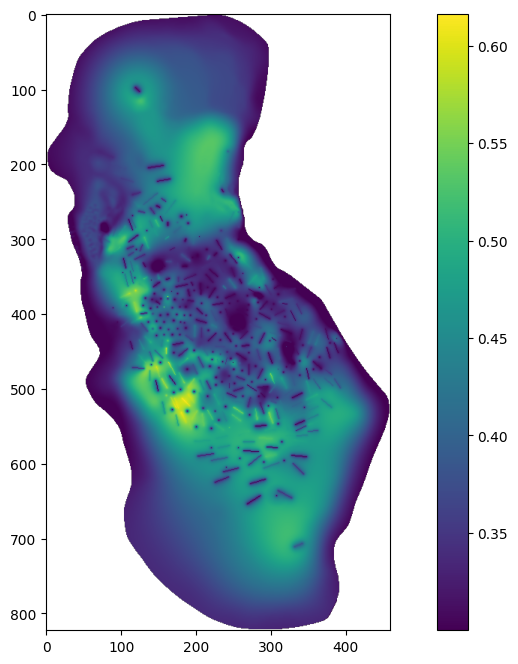

In [58]:
# optimal_gamma = 0.017158806351958475
# updated_saturation = calculate_current_saturation(optimal_gamma, flat_S_H0, current_saturation, R, distances, weights, matrix_r_ij, init_So_value, mask).reshape(S_H0.shape)
updated_saturation = calculate_current_saturation(optimal_gamma, flat_S_H0, delta_So, coef, mask).reshape(S_H0.shape)

print("Разница в процентах:", 
      (np.sum((S_H0 - 
                   updated_saturation)
                   * data_volumes) - Qo_sum_V) / Qo_sum_V * 100)

print("loss:",
      (np.sum((S_H0 - updated_saturation) * data_volumes) - Qo_sum_V) ** 2)

updated_saturation[updated_saturation == 0] = np.nan

plt.imshow(updated_saturation, origin="upper") #, vmin=0.3, vmax=1)
# plt.imshow(updated_saturation, origin="upper")
plt.colorbar()
levels = 15
# Добавляем изолинии
# contour = plt.contour(updated_saturation,levels=levels, colors='black', linewidths=0.5)
# Можно добавить подписи к изолиниям
# plt.clabel(contour, inline=True, fontsize=6)

# for well_geom in data_wells["LINESTRING_new"]:
#     x_line, y_line = well_geom.xy
#     plt.plot(x_line, y_line, color="black", linewidth=2)
# x_pix, y_pix = np.array(data_wells[data_wells['work_marker']=='prod'].T1_x_new), np.array(data_wells[data_wells['work_marker']=='prod'].T1_y_new)
# plt.scatter(x_pix, y_pix, c="red", marker="x", label="Скважины")  # Отмечаем скважины
# x_pix, y_pix = np.array(data_wells[data_wells['work_marker']=='inj'].T1_x_new), np.array(data_wells[data_wells['work_marker']=='inj'].T1_y_new)
# plt.scatter(x_pix, y_pix, c="red", marker='^', label="Скважины")  # Отмечаем скважины

# # Подписи для скважин с смещением
# for i in range(len(data_wells['well_number'])):
#     plt.text(data_wells['T1_x_new'][i], data_wells['T1_y_new'][i]+5, f"{data_wells['well_number'][i]}", fontsize=7, ha='center')


plt.savefig(f"updated_saturation_4.png", dpi=500) 

In [62]:
# Сохранение насыщенности в npy
np.save("updated_saturation.npy", updated_saturation)

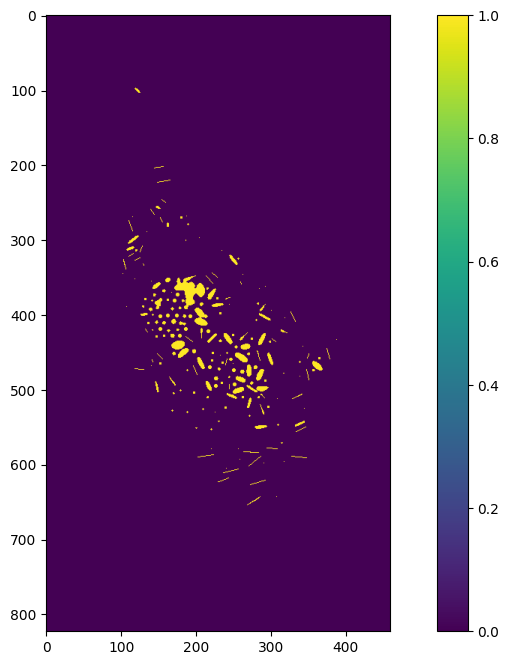

In [109]:
plt.imshow((updated_saturation) < data_saturation*(1 - KIN), origin="upper")
     
plt.colorbar()
plt.show()

In [110]:
data_wells.Qo_cumsum.sum()

8752395.4

### Расчет карты начальных извлекаемых (или подвижных?) запасов

In [95]:
# НГЗ - oil initially in place 
map_OIIP  = data_NNT * data_saturation * data_porosity * pho_surf * 10000  / Bo # умножение на 10000 требуется для перевода единиц измерения плотности запасов из тонн/м2 в тонн/га
OIIP = np.sum(map_OIIP * default_size_pixel ** 2 / 10000)
print(f"НГЗ NGT - 84882 тыс.т")
print(f"НГЗ расчет через ННТ - {OIIP / 1000} тыс.т")

НГЗ NGT - 84882 тыс.т
НГЗ расчет через ННТ - 84834.144 тыс.т


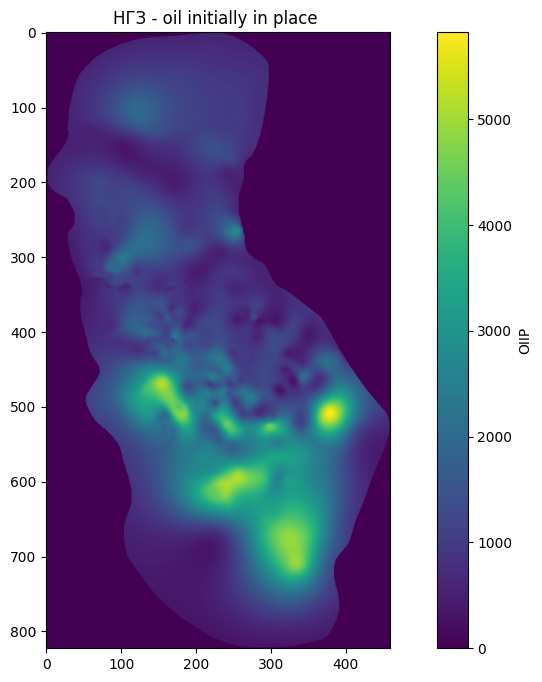

In [96]:
plt.imshow(map_OIIP, cmap="viridis", origin="upper")  
plt.colorbar(label="OIIP") 
plt.title("НГЗ - oil initially in place ")
plt.show()

In [97]:
# НИЗ - initial recoverable reserves of oil
print('НИЗ согласно NGT у этой залежи - 28457.61 тыс.т')
map_irr = map_OIIP * KIN
init_recoverable_reserves = OIIP * KIN
print(f'НИЗ расчет - {init_recoverable_reserves  / 1000} тыс.т')

НИЗ согласно NGT у этой залежи - 28457.61 тыс.т
НИЗ расчет - 28504.272384000004 тыс.т


In [98]:
# ОИЗ согласно карте NGT у большой залежи - 20131.86 тыс.т (без кита)
# ОИЗ NGT с китом - 21895.77 тыс.т
# 10000 - перевод т/га в т/м2
# 1000 - перевод т в тыс.т
print('ОИЗ NGT с китом - 21895.77 тыс.т')
reserves = np.sum(data_rrr * default_size_pixel ** 2 / 10000) / 1000
print(f'ОИЗ карта NGT с китом - {reserves} тыс.т')

ОИЗ NGT с китом - 21895.77 тыс.т
ОИЗ карта NGT с китом - 22137.09 тыс.т


In [99]:
updated_saturation[np.isnan(updated_saturation)] = 0

In [100]:
# ОГЗ - remaining Oil in Place
map_ROIP = data_NNT * updated_saturation * data_porosity * pho_surf * 10000  / Bo
ROIP = np.sum(map_ROIP * default_size_pixel ** 2 / 10000)
print('ОГЗ NGT - 76005.04 тыс.т')
print(f'ОГЗ расчет - {ROIP / 1000} тыс.т')

ОГЗ NGT - 76005.04 тыс.т
ОГЗ расчет - 75991.184 тыс.т


In [107]:
# ОИЗ - residual_recoverable_reserves
map_rrr = map_ROIP - map_OIIP * (1 - KIN)
residual_recoverable_reserves = np.sum(map_rrr[map_rrr >= 0] * default_size_pixel ** 2 / 10000)
residual_recoverable_reserves_must = (ROIP + Qo_sum) * KIN - Qo_sum
print('ОИЗ NGT - 20131.86 тыс.т')
print(f'ОИЗ расчет - {residual_recoverable_reserves / 1000} тыс.т')
residual_recoverable_reserves_must / 1000

ОИЗ NGT - 20131.86 тыс.т
ОИЗ расчет - 19752.014 тыс.т


19721.44727840005

In [106]:
map_rrr[map_rrr < 0] = 0

In [103]:
print(f'(НИЗ - ОИЗ): {(init_recoverable_reserves - residual_recoverable_reserves) / 1000}')

(НИЗ - ОИЗ): 8752.258384000002


In [104]:
Qo_sum/1000

8752.395399999925

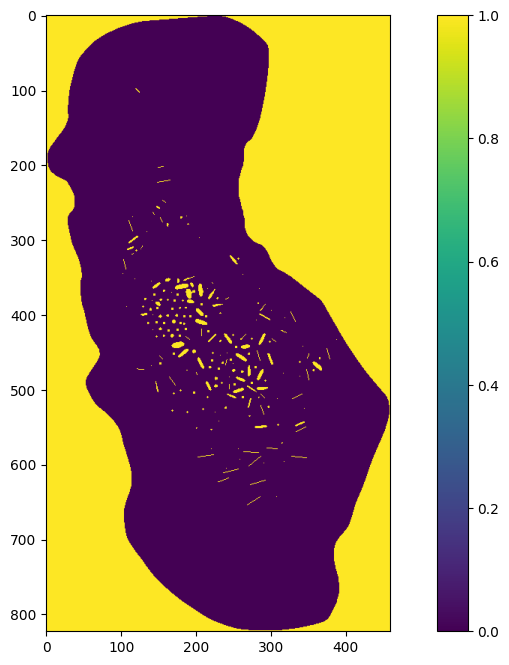

In [236]:
plt.imshow(map_rrr == 0, cmap="viridis", origin="upper")  
plt.colorbar() 
plt.savefig(f"magic.png", dpi=500) 

In [237]:
updated_saturation[updated_saturation > 0.0].min()

0.3

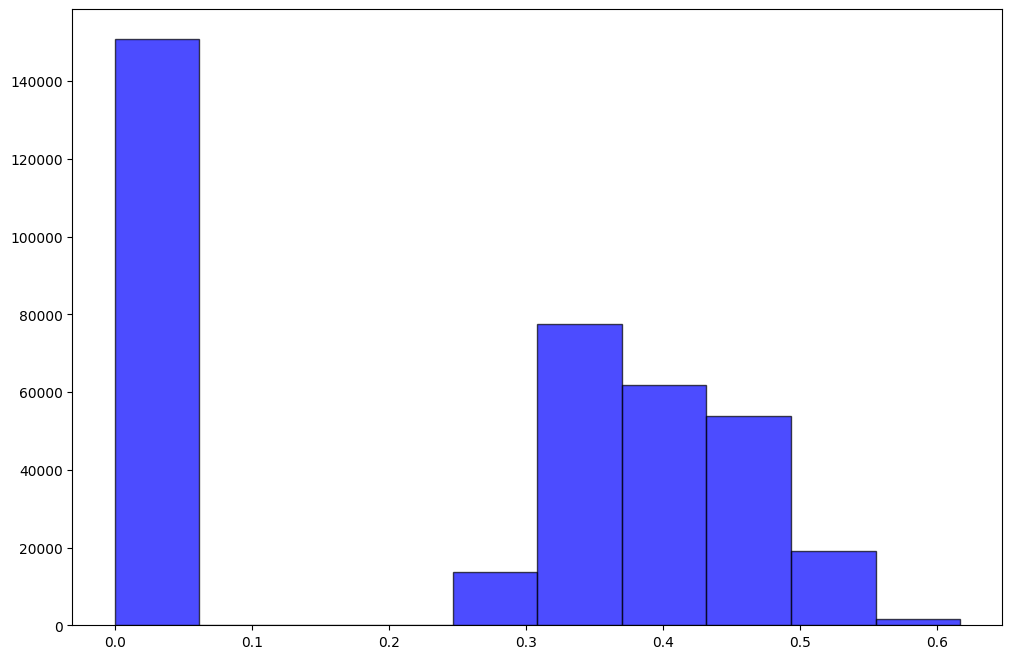

In [238]:
plt.hist(updated_saturation.ravel(), color='blue', alpha=0.7, edgecolor='black')
plt.show()

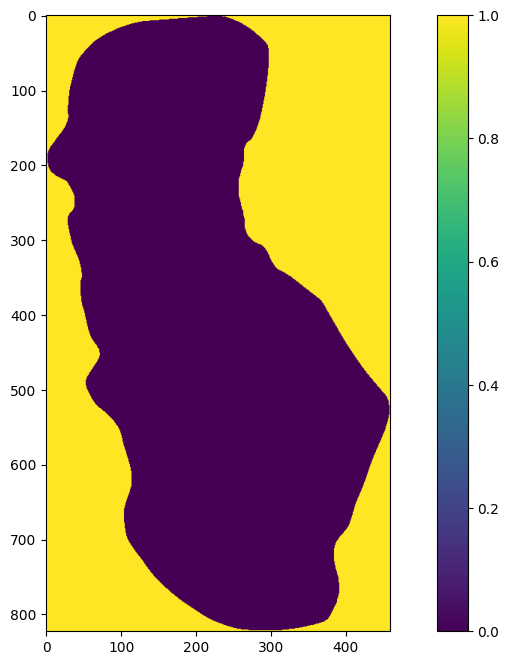

In [156]:
plt.imshow(updated_saturation < 0.3, cmap="viridis", origin="upper")  
plt.colorbar() 
plt.show()

In [157]:
# updated_saturation_old = np.load(r'C:\Users\setup\Desktop\ОИЗ\updated_saturation_alina.npy')

In [158]:
# plt.imshow((updated_saturation_old-updated_saturation), origin="upper")
     
# plt.colorbar()
# plt.show()

### Обводненность

0.30014986


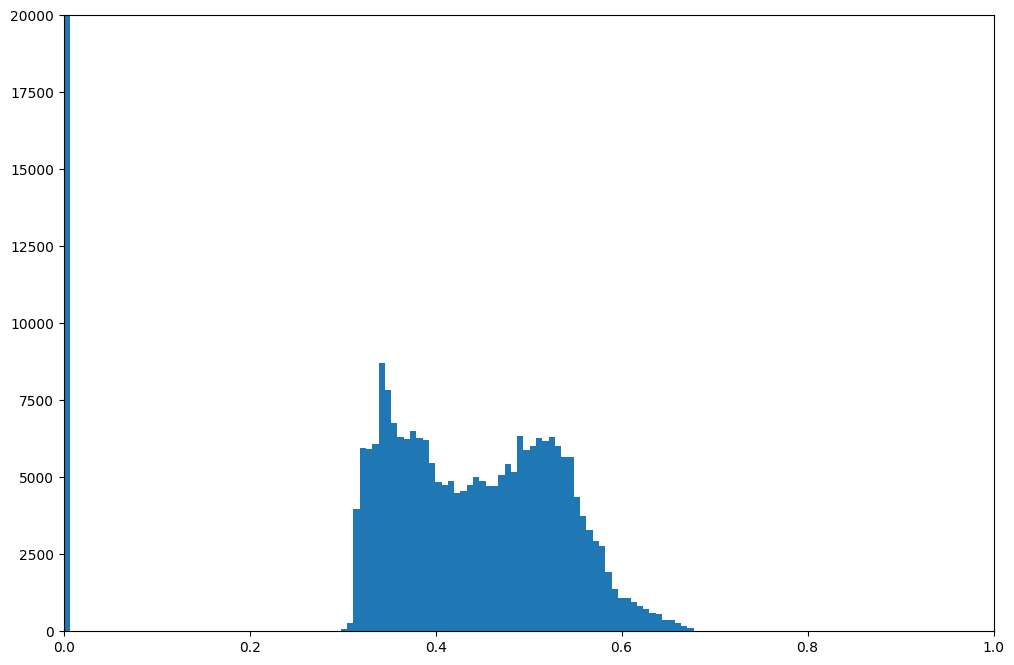

In [159]:
# Оставляем только насыщенность выше Sor
data_saturation[data_saturation < 0.3] = 0
print(np.nanmin(data_saturation[data_saturation > 0]))
plt.hist(data_saturation.flatten(), bins=100)
plt.xlim(0, 1)
plt.ylim(0, 20000);

In [160]:
Sw = 1.0 - updated_saturation 

In [161]:
Swc = 1.0 - data_saturation

In [162]:
# Sor =  np.maximum(data_saturation * (1 - KIN), 0.3)

In [163]:
Sw[334, 154]

0.6951382

In [164]:
Sor[334, 154]

TypeError: 'float' object is not subscriptable

In [185]:
updated_saturation[updated_saturation > 0.1].min()

0.3

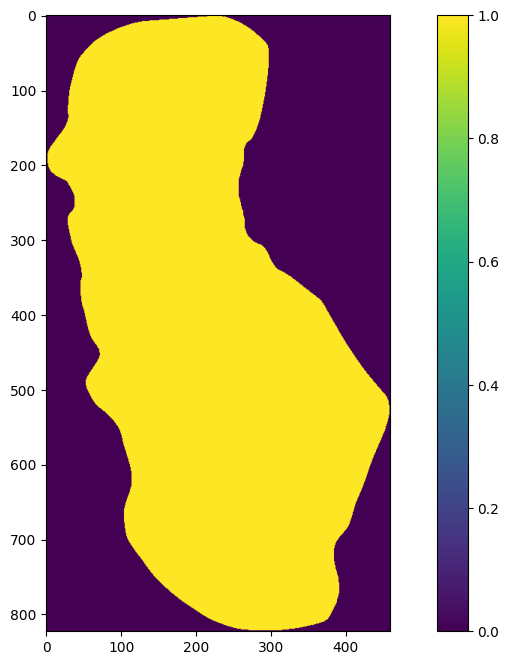

In [166]:
plt.imshow(updated_saturation - data_saturation < 0, origin="upper")
plt.colorbar()
plt.show()

In [167]:
# Получаем соответствующие значения (если нужно):
updated_saturation_negative = updated_saturation[data_saturation - updated_saturation < 0]
data_saturation_negative = data_saturation[data_saturation - updated_saturation < 0]

# Или индексы этих значений:
indices = np.argwhere(updated_saturation - data_saturation < 0)

In [168]:
updated_saturation_negative

array([], dtype=float32)

In [169]:
data_saturation_negative

array([], dtype=float32)

In [170]:
len(indices)

227612

In [171]:
mu_w = 0.29  
mu_o = 0.72 
Bo = 1.241   
Bw = 1.0     
Fw = 0.3     
Fo = 1.0    
m1 = 1       
m2 = 1      
# Swc = 0.2     
Sor = 0.3    

In [172]:
def get_f_w(mu_w, mu_o, Bo, Bw, Sw, Fw, m1, Fo, m2, Swc, Sor):
    """
    Обводненность продукции скважины от водонасыщенности Sw - Функция Баклея-Леверетта
    """
    k_rw = get_k_corey(Fw, m1, Swc, Sor, Sw, type="water")  # ОФП по воде

    k_ro = get_k_corey(Fo, m2, Swc, Sor, Sw, type="oil")  # ОФП по нефти
    try:
        f_w = 100 / (1 + (k_ro * mu_w * Bw) / (k_rw * mu_o * Bo))
    except ZeroDivisionError:
        f_w = 0
    return f_w

In [173]:
def get_k_corey(F, m, Swc, Sor, Sw, type):
    """Относительные фазовые проницаемости по нефти/воде от водонасыщенности Sw (по Кори)"""
    if Sw == 1 and type == "water":
        return 1
    elif Sw == 1 and type == "oil":
        return 0
    else:
        try:
            Sd = (Sw - Swc) / (1 - Sor - Swc)  # Приведенная водонасыщенность пласта
            if Sd < 0:
                print(f"Swc - {Swc}")
                print((1 - Sor - Swc))
        except ZeroDivisionError:
            Sd = 1
        if type == "water":
            return F * (Sd ** m)
        elif type == 'oil':
            return F * ((1 - Sd) ** m)

In [180]:
vectorized_get_f_w = np.vectorize(get_f_w)
f_w_array = vectorized_get_f_w(mu_w, mu_o, Bo, Bw, Sw, Fw, m1, Fo, m2, Swc, Sor)

C:\Users\Alina\AppData\Local\Temp\ipykernel_14012\2273799749.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  Sd = (Sw - Swc) / (1 - Sor - Swc)  # Приведенная водонасыщенность пласта
C:\Users\Alina\AppData\Local\Temp\ipykernel_14012\2834468693.py:9: RuntimeWarning: invalid value encountered in scalar divide
  f_w = 100 / (1 + (k_ro * mu_w * Bw) / (k_rw * mu_o * Bo))


In [175]:
Swc[Swc < 1].max()

0.69985014

In [176]:
updated_saturation.max()

0.6170355

In [186]:
map_rrr[553, 220]

0.0

In [84]:
indices = np.argwhere((data_saturation<0.35) & (data_saturation>0))
indices

array([[  1, 215],
       [  1, 216],
       [  1, 217],
       ...,
       [821, 312],
       [821, 313],
       [821, 314]], dtype=int64)

In [187]:
updated_saturation[553, 220]

0.30434957

In [188]:
f_w_array[553, 220]

98.1483294144154

In [78]:
indices = np.argwhere((map_rrr == 0))
indices

array([[  0,   0],
       [  0,   1],
       [  0,   2],
       ...,
       [822, 457],
       [822, 458],
       [822, 459]], dtype=int64)

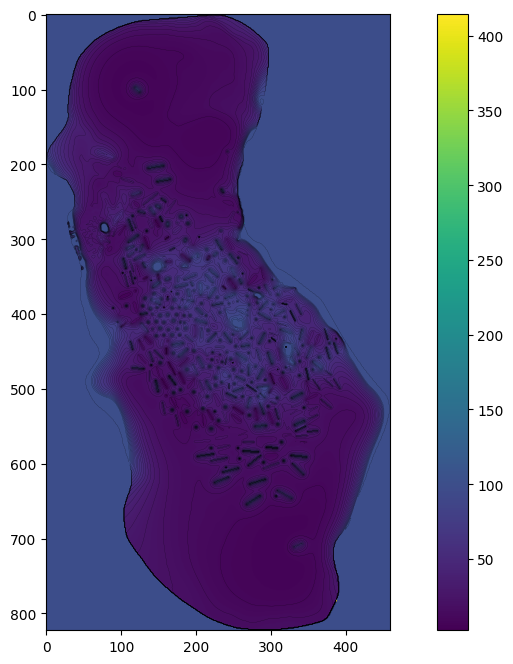

In [184]:
# extent=[0, f_w_array.shape[1], f_w_array.shape[0], 0]
# создаём координатную сетку
x = np.arange(f_w_array.shape[1])
y = np.arange(f_w_array.shape[0])
X, Y = np.meshgrid(x, y)


img = plt.imshow(f_w_array, origin="upper") #, extent=extent)
# plt.contour(f_w_array, colors='white', linewidths=0.8)
levels = np.arange(0, 101, 5)
plt.contour(X, Y, f_w_array, levels=levels, colors='black',  linewidths=0.1)
     
plt.colorbar(img) 

# plt.xlim(103, 109)
# plt.ylim(203, 209)
# plt.show()
plt.savefig(f"water_cut.png", dpi=500) 

### Сохранение в GRD

In [69]:
from osgeo import gdal
filename = f"{os.getcwd()}/f_w_array.grd"
filename_copy = filename.replace(".grd", "") + "_copy.grd"
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(filename_copy, f_w_array.shape[1], f_w_array.shape[0], 1, gdal.GDT_Float32)
dataset.SetGeoTransform(maps[type_map_list.index("initial_oil_saturation")].geo_transform)
dataset.SetProjection(maps[type_map_list.index("initial_oil_saturation")].projection)
dataset.GetRasterBand(1).WriteArray(f_w_array)
dataset.FlushCache()
src_dataset = gdal.Open(filename_copy, gdal.GA_ReadOnly)
# driver = gdal.GetDriverByName('XYZ') можно использовать для формата .dat
driver = gdal.GetDriverByName('GSAG')
driver.CreateCopy(filename, src_dataset, 0, options=['TFW=NO'])
# Удаляем временный файл
src_dataset = None
dataset = None
os.remove(filename_copy)
os.remove(filename.replace(".grd", "") + ".grd.aux.xml")

C:\Users\Alina\Desktop\Python\!Работа IT ННГ\Infill_drilling\Infill_drilling\.venv\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [ ]:
НГЗ = area * NNT * So * m * pho / Bo

In [ ]:
ОГЗ = НГЗ - НДН

In [ ]:
ОИЗ = НИЗ - НДН
ОИЗ = НГЗ * КИН - НДН

In [ ]:
НИЗ = НГЗ * КИН
ОИЗ != ОГЗ * КИН

In [ ]:
ОИЗ = НГЗ * КИН - НДН
НДН_model = area * NNT * So * m * pho / Bo * КИН - area * NNT * So_current * m * pho / Bo

In [ ]:
ОИЗ = НИЗ - НДН
НДН = НГЗ - ОГЗ
ОИЗ = НИЗ - (НГЗ - ОГЗ)
ОИЗ = НГЗ * КИН - (НГЗ - ОГЗ)
ОИЗ = НГЗ * КИН - НГЗ + ОГЗ
ОИЗ = ОГЗ - НГЗ * (1 - КИН)

ОИЗ = (So_current - So * (1 - КИН)) * volume

Квыт = (Sнн - Sor) / Sнн


In [ ]:
НГЗ = area * NNT * So * m * pho / Bo
ОГЗ = area * NNT * So_current * m * pho / Bo

In [ ]:
0 = (So_min - So * (1 - КИН)) 

In [ ]:
So_min = So * (1 - КИН)

In [156]:
0.3 - 0.3 * (1 - 0.3)

0.09

In [ ]:
So_current >= So * (1 - КИН)
So_current >= So - So * КИН
КИН >= (So - So_current) / So

In [319]:
(0.5 - 0.3) / 0.5

0.4

In [321]:
0.5 * (1 - 0.3)

0.35